Letter Analysis

In [1]:
import os
import paramiko
import pandas as pd
from scp import SCPClient
from posixpath import join
import matplotlib.pyplot as plt

run_id = 0

jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'
hdfs_dir = '/user/hadoop/historical_analysis'
local_dir = '../resources/historical_analysis/'
local_input_dir = local_dir + 'input'
local_output_dir = local_dir + f'output_{run_id}'

c:\Users\Utente\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


First analyze the letter frequencies in books across the eras. As performance is not relevant now, the job will be executed with 1 reducer, using combiner.
We hypotize that the input files are already in the input folder in hdfs, in /user/hadoop/letter_analysis/input/.

In [28]:
# connect with ssh
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')

# run the job for each file
for txt_file in os.listdir(local_input_dir):
    print(f'Processing {txt_file}')
    hdfs_input_dir = join(hdfs_dir, 'input', txt_file)
    hdfs_output_dir = join(hdfs_dir, f'output_{run_id}', txt_file.split('.')[0])
    stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '
                                             f'{hdfs_input_dir} {hdfs_output_dir}/count {hdfs_output_dir}/freq 1 inmappercombiner')
    print(stderr.read().decode('utf-8'))
    print(stdout.read().decode('utf-8'))

# copy from hdfs to virtual machine
stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal {hdfs_dir}/output_{run_id} .')
print(stderr.read().decode('utf-8'))

# copy from virtual machine to local machine
if not os.path.exists(local_output_dir):
    os.mkdir(local_output_dir)    
scp = SCPClient(ssh.get_transport())
scp.get(f'output_{run_id}', local_dir, recursive=True)

# remove the output from virtual machine
ssh.exec_command(f'rm -r output_{run_id}')

scp.close()
ssh.close()

After that we can analyze the output files.

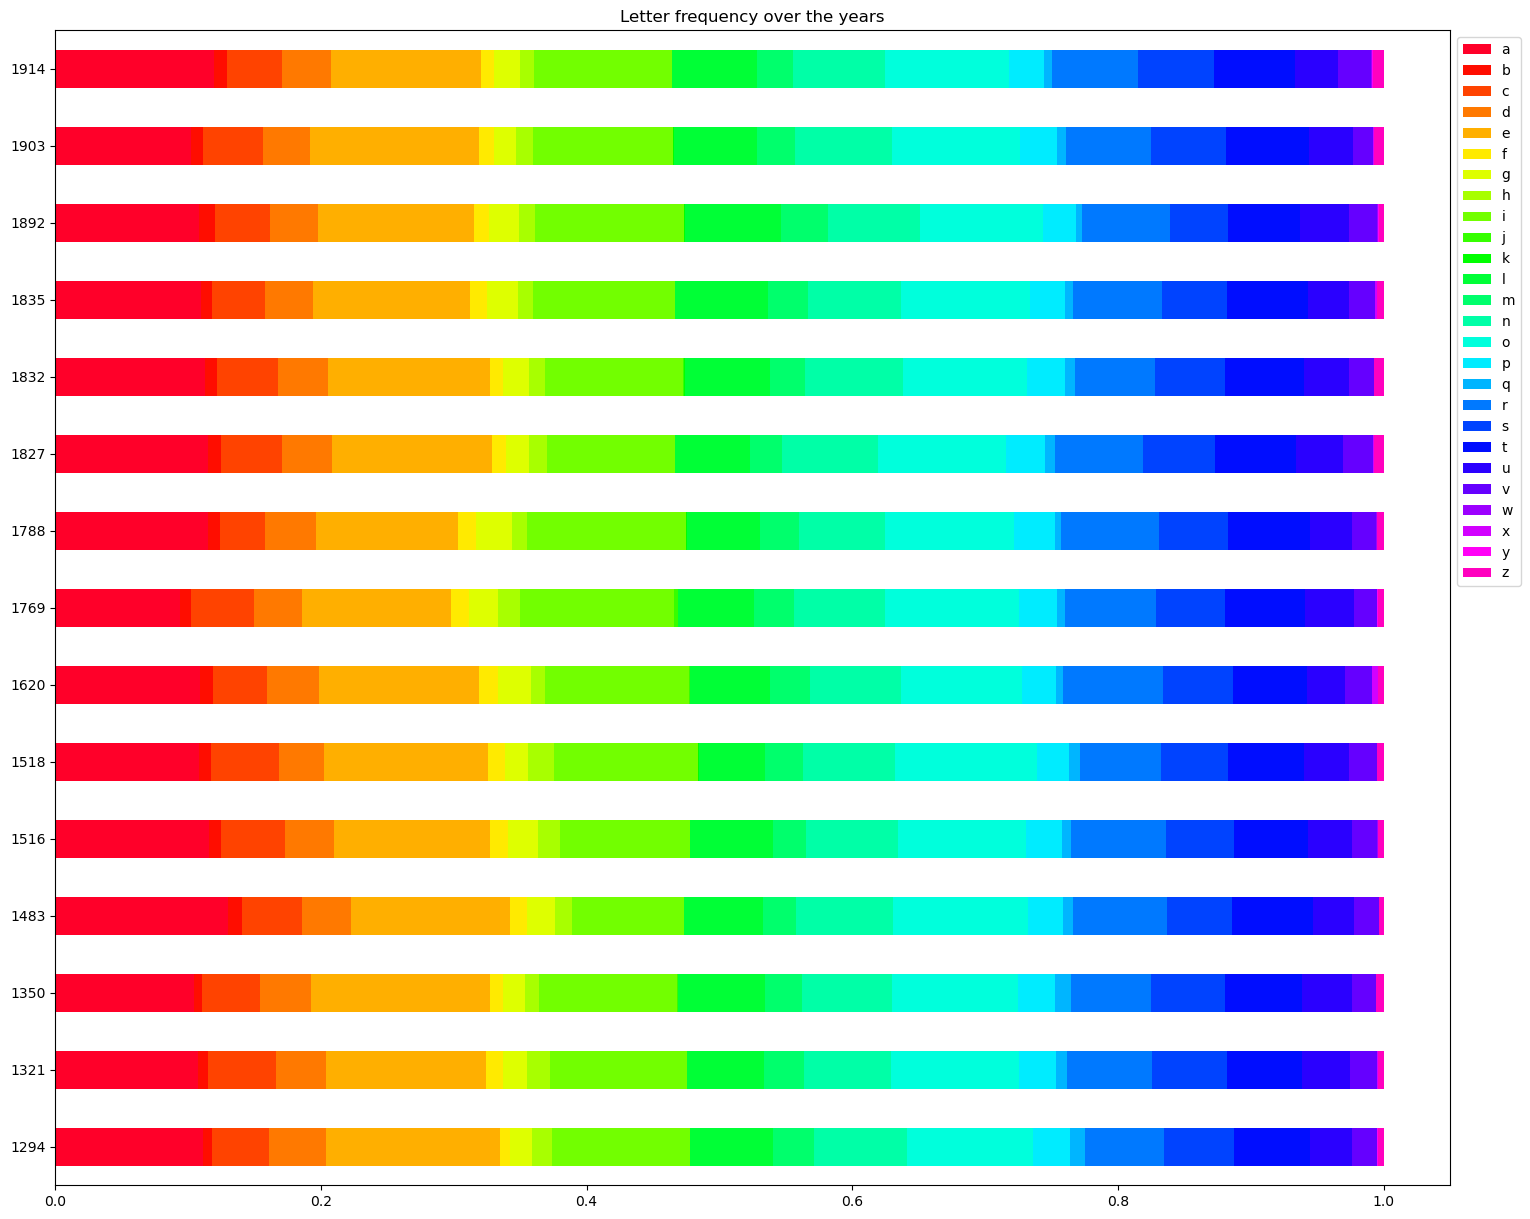

In [2]:
years = []
for filename in os.listdir(local_output_dir):
    year = filename.split('.')[0]
    years.append(year)

df = pd.DataFrame(index=years, columns=[])

for year in years:
    freq_per_year = []
    filepath = f'{local_output_dir}/{year}/freq/part-r-00000'
    with open(filepath, 'r') as f:
        for line in f:
            letter, freq = line.strip().split('\t')
            freq = float(freq)
            df.loc[year, letter] = freq

ax = df.plot( kind='barh', stacked=True, title='Letter frequency over the years', figsize=(18, 15), colormap='gist_rainbow', rot=0)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()